# Data Engineering

In [667]:
import missingno as msno
import pandas as pd
from numpy import nan, sin, cos, pi
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [668]:
data = pd.read_csv("../docs/dataset_DT.csv")
data.dtypes

age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day          float64
month         object
duration     float64
campaign     float64
pdays        float64
previous     float64
poutcome      object
y             object
dtype: object

In [669]:
for col in data.columns:
    if data[col].dtype == "object":
        data[col] = data[col].replace([nan, "", " ", "unknown"], pd.NA)

data["pdays"] = data["pdays"].replace([-1], [float(nan)])


<Axes: >

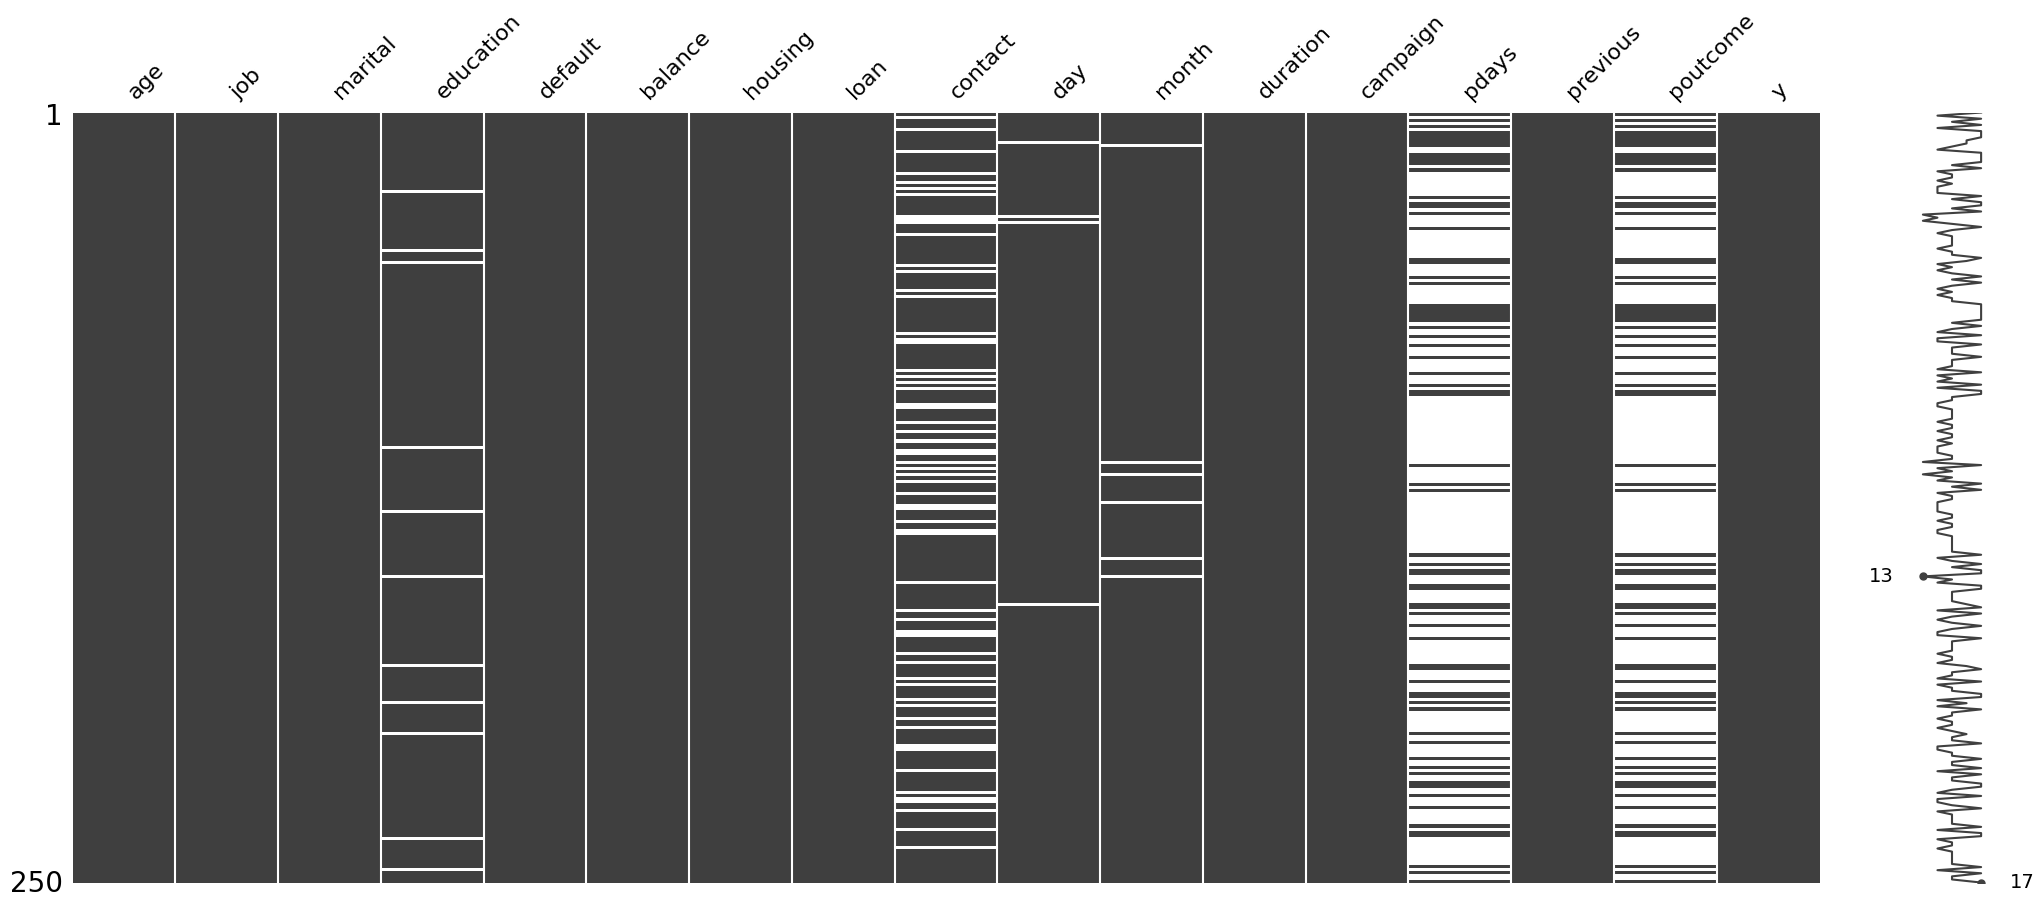

In [670]:
msno.matrix(data.sample(250))

<Axes: >

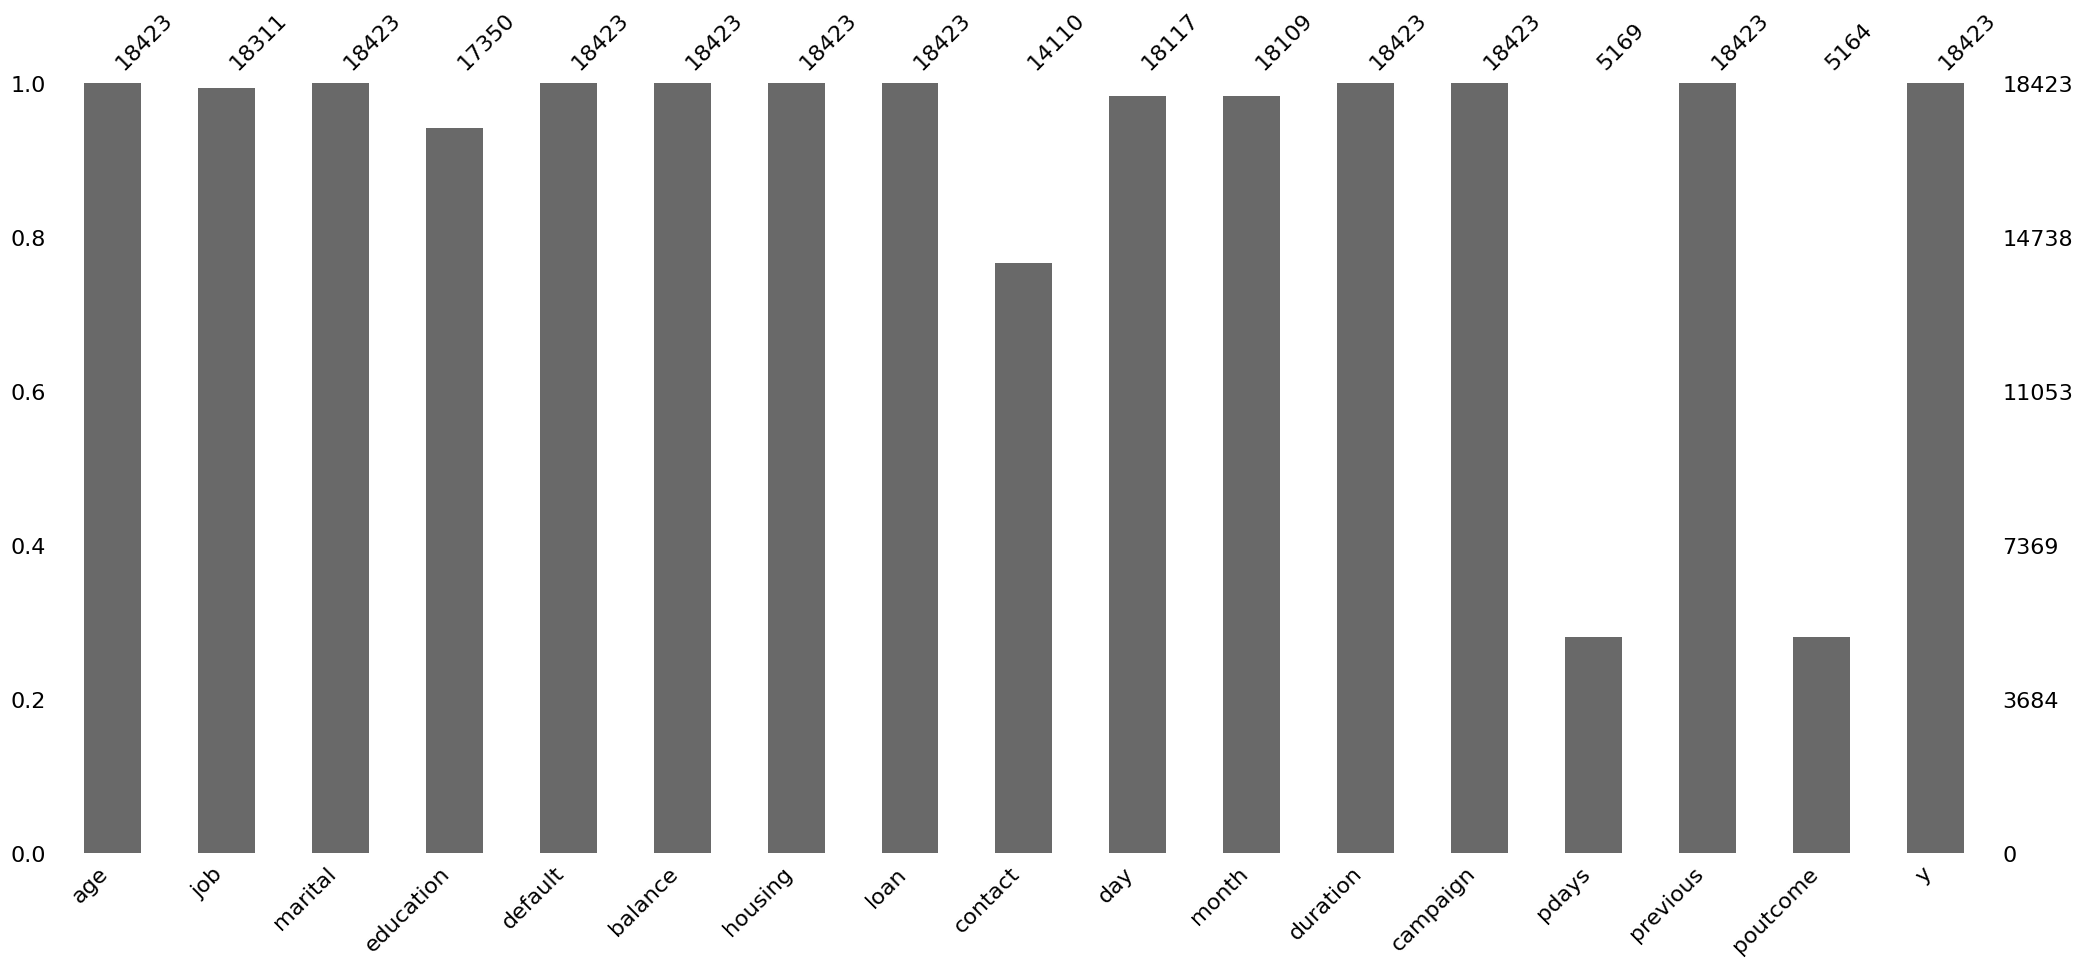

In [671]:
msno.bar(data)

<Axes: >

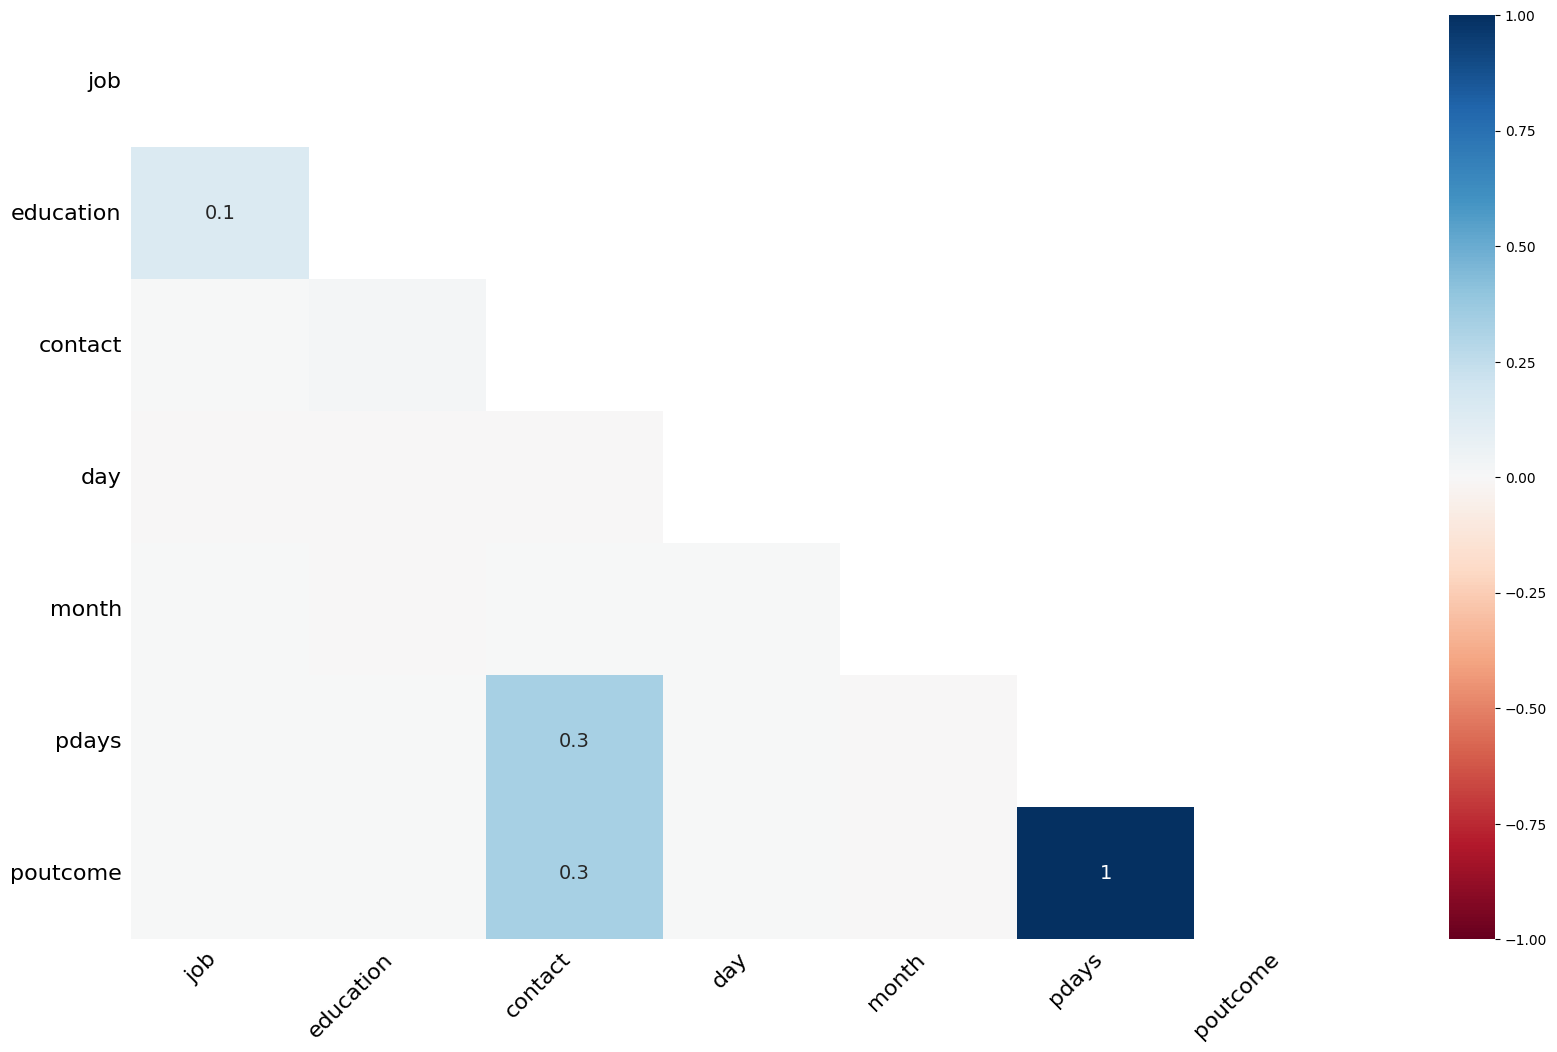

In [672]:
msno.heatmap(data)

<Axes: >

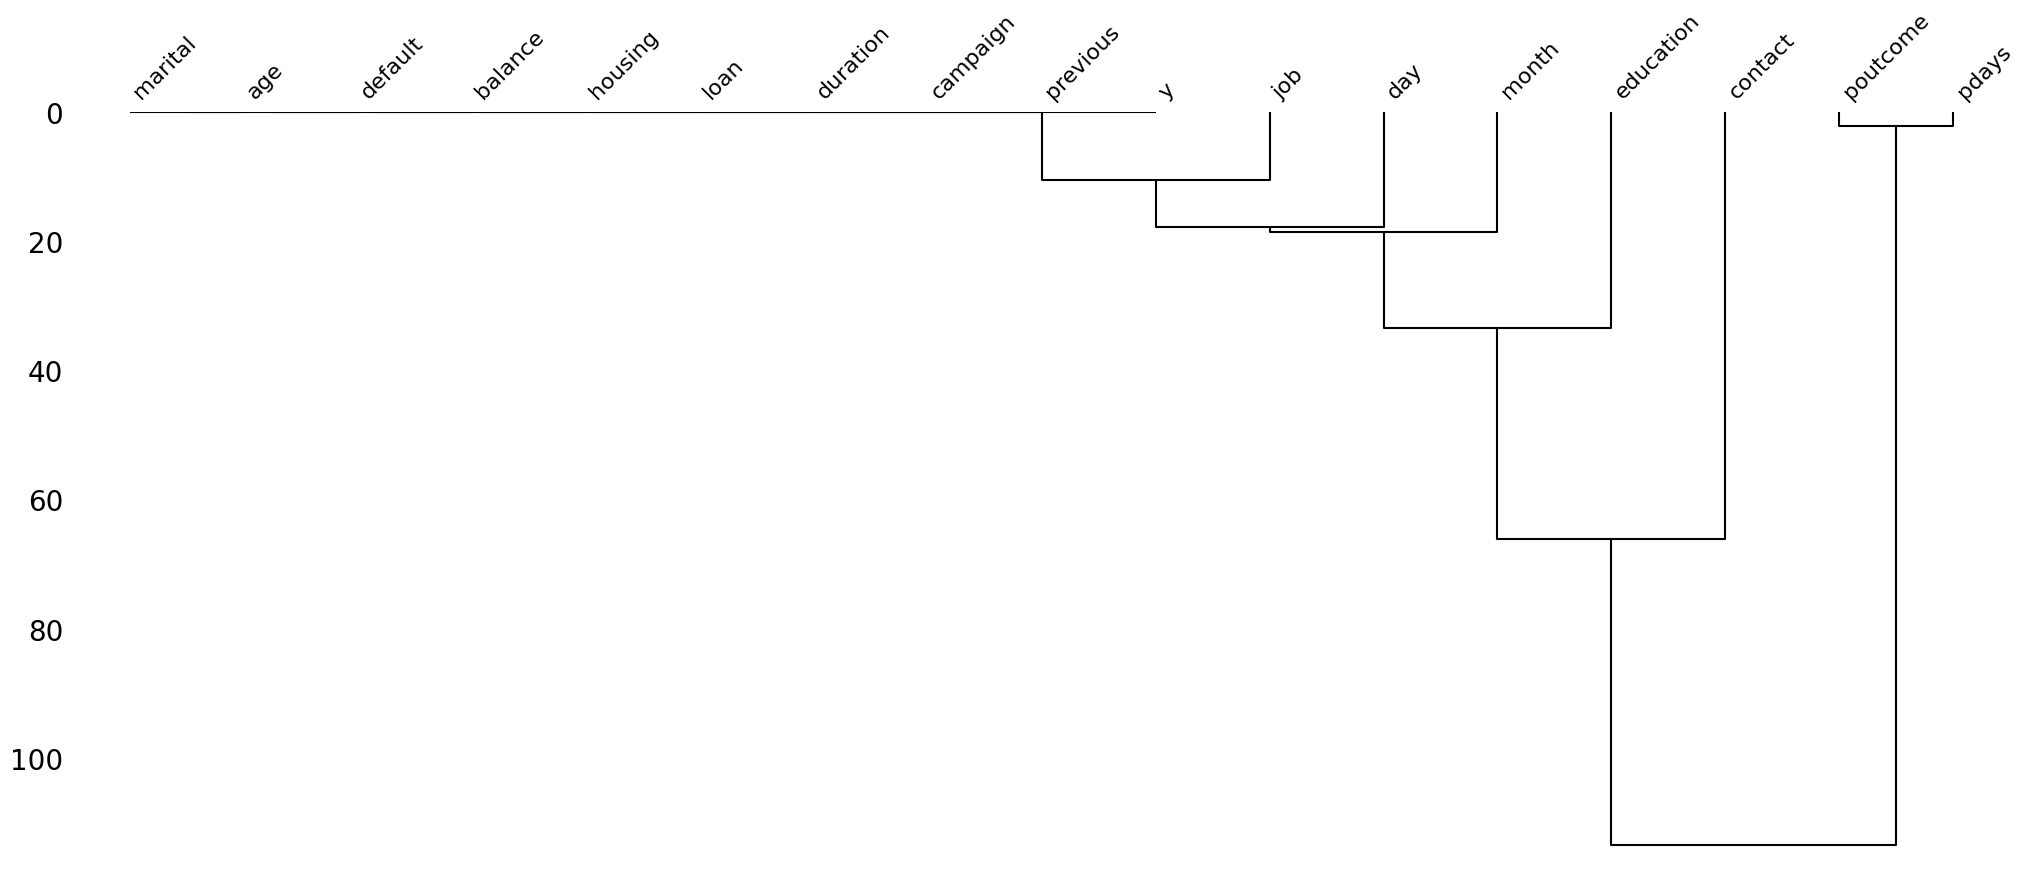

In [673]:
msno.dendrogram(data)

In [694]:
percent_missing = data.isnull().sum() * 100 / len(data)

print(percent_missing)

age                  0.0
education            0.0
balance              0.0
duration             0.0
campaign             0.0
pdays                0.0
previous             0.0
y                    0.0
day_of_week          0.0
month                0.0
month_sin            0.0
month_cos            0.0
day_of_week_sin      0.0
day_of_week_cos      0.0
job_admin.           0.0
job_blue-collar      0.0
job_entrepreneur     0.0
job_housemaid        0.0
job_management       0.0
job_retired          0.0
job_self-employed    0.0
job_services         0.0
job_student          0.0
job_technician       0.0
job_unemployed       0.0
marital_divorced     0.0
marital_married      0.0
marital_single       0.0
default_no           0.0
default_yes          0.0
housing_no           0.0
housing_yes          0.0
loan_no              0.0
loan_yes             0.0
contact_cellular     0.0
contact_telephone    0.0
contact_unknown      0.0
poutcome_failure     0.0
poutcome_other       0.0
poutcome_success     0.0


In [675]:
data.dropna(subset=["job"], inplace=True)

In [676]:
# Drop records where poutcome is null and pdays is not. This is likely a sampling error.
data = data[~((data["poutcome"].isnull()) & (data["pdays"].notnull()))]

In [677]:
data["education"] = data["education"].fillna("unknown")

In [678]:
# Creating day to int from float
data["day"] = pd.to_numeric(data["day"], errors="coerce").fillna(0).astype(int)
data["day"]

0         1
1         1
2         1
3         1
4         1
         ..
18418    30
18419    30
18420    30
18421    30
18422    30
Name: day, Length: 18306, dtype: int64

In [679]:
# Define a function to handle day and month data, and add the year 2024
def create_date(row):
    """Creates a date from the 'day' and 'month' columns in a DataFrame row, assuming the year is 2024.

    The function handles potential errors in day and month values and returns NaT (Not a Time)
    if a valid date cannot be created.

    Args:
        row (pandas.Series): A row from a Pandas DataFrame containing 'day' and 'month' columns.

    Returns:
        pandas.Timestamp or pandas.NaT:
            - A pandas Timestamp representing the created date if successful.
            - NaT (Not a Time) if either 'day' or 'month' is missing or if there's an error
              converting the values to a date.
    """
    # Only create date if both day and month are available
    if pd.notna(row["day"]) and pd.notna(row["month"]):
        try:
            # Ensure that day is integer if possible
            day = int(row["day"])
            # Use the month from the row and assume 2024 as the year
            return pd.to_datetime(f'2024-{row["month"]}-{day}', format="%Y-%b-%d", errors="coerce")
        except Exception:
            return pd.NaT  # Return a NaT (Not a Time) if any error occurs
    else:
        return pd.NaT  # Return NaT if either day or month is missing


# Apply the function to each row
data["date"] = data.apply(create_date, axis=1)

# Fill forward the missing dates by propagating the previous non-null date
data["date"] = data["date"].ffill()

In [680]:
data = data.drop(["day", "month"], axis=1)
data["day_of_week"] = data["date"].dt.day_of_week
data["month"] = data["date"].dt.month
data = data.drop("date", axis=1)

In [681]:
# Sine and cosine transformation for months (1-12)
data["month_sin"] = sin(2 * pi * data["month"] / 12)
data["month_cos"] = cos(2 * pi * data["month"] / 12)

# Sine and cosine transformation for day of the week (0-6)
data["day_of_week_sin"] = sin(2 * pi * data["day_of_week"] / 7)
data["day_of_week_cos"] = cos(2 * pi * data["day_of_week"] / 7)

In [682]:
data.head(25)

,age,job,marital,education,default,balance,housing,loan,contact,duration,...,pdays,previous,poutcome,y,day_of_week,month,month_sin,month_cos,day_of_week_sin,day_of_week_cos
0,34.0,blue-collar,single,secondary,no,13408.0,no,no,cellular,647.0,...,NaN,0.0,<NA>,no,0,4,0.866025,-0.5,0.0,1.0
1,49.0,management,divorced,tertiary,no,20727.0,no,no,cellular,285.0,...,132.0,2.0,failure,no,0,4,0.866025,-0.5,0.0,1.0
2,32.0,services,single,tertiary,no,1743.0,yes,no,cellular,1156.0,...,261.0,3.0,other,no,0,4,0.866025,-0.5,0.0,1.0
3,46.0,management,divorced,tertiary,no,10469.0,yes,no,cellular,202.0,...,NaN,0.0,<NA>,no,0,4,0.866025,-0.5,0.0,1.0
4,26.0,management,single,tertiary,no,7628.0,no,no,cellular,263.0,...,NaN,0.0,<NA>,no,0,4,0.866025,-0.5,0.0,1.0
5,54.0,retired,married,secondary,no,1004.0,yes,no,cellular,479.0,...,307.0,1.0,failure,no,0,4,0.866025,-0.5,0.0,1.0
6,32.0,technician,single,tertiary,no,392.0,yes,no,cellular,957.0,...,131.0,2.0,failure,no,0,4,0.866025,-0.5,0.0,1.0
7,37.0,management,married,secondary,no,1180.0,yes,yes,cellular,786.0,...,135.0,1.0,other,no,0,4,0.866025,-0.5,0.0,1.0
8,33.0,admin.,single,secondary,no,285.0,yes,no,cellular,427.0,...,329.0,1.0,other,no,0,4,0.866025,-0.5,0.0,1.0
9,46.0,self-employed,divorced,tertiary,no,926.0,yes,no,cellular,463.0,...,133.0,3.0,failure,no,0,4,0.866025,-0.5,0.0,1.0


In [683]:
# Define the custom order for education
custom_order = ["unknown", "primary", "secondary", "tertiary"]

# Create a mapping from each category to an integer based on the order
education_map = {category: idx for idx, category in enumerate(custom_order)}

# Apply the mapping to the column (including NaN handling)
data["education"] = data["education"].apply(
    lambda x: education_map[x] if x in education_map else None
)

In [684]:
data["pdays"] = data["pdays"].fillna(-1)
data["poutcome"] = data["poutcome"].fillna("unknown")

In [685]:
def one_hot_encode_column(df, column, treat_missing_as_category=False):
    """One-hot encodes a specified column in the DataFrame.

    Optionally, treats missing values (NaN) as a separate category.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The name of the column to one-hot encode.
    treat_missing_as_category (bool): If True, treat NaN as a separate category.

    Returns:
    pd.DataFrame: A DataFrame with the one-hot encoded column.
    """
    # If missing values should be treated as a separate category, fill NaNs with a placeholder
    if treat_missing_as_category:
        df[column] = df[column].fillna("unknown")

    # One-hot encode the column
    df_encoded = pd.get_dummies(df, columns=[column], prefix=column)

    return df_encoded


data = one_hot_encode_column(data, "job")
data = one_hot_encode_column(data, "marital")
data = one_hot_encode_column(data, "default")
data = one_hot_encode_column(data, "housing")
data = one_hot_encode_column(data, "loan")
data = one_hot_encode_column(data, "contact", True)
data = one_hot_encode_column(data, "poutcome")

In [686]:
# Apply the mapping to the column (including NaN handling)
data["y"] = data["y"].map({"yes": 1, "no": 0})

In [687]:
data.to_csv("../docs/out.csv")

<Axes: >

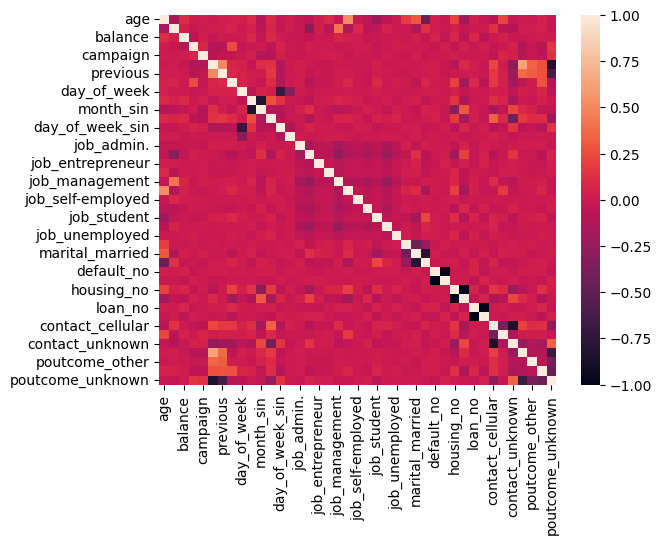

In [692]:
sns.heatmap(data.corr())

In [688]:
y = data["y"]
X = data.drop(["y"], axis=1)

In [689]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split data before balancing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [690]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Fit the classifier to the data
dt_clf = DecisionTreeClassifier(random_state=8)
dt_clf.fit(X_train_resampled, y_train_resampled)

# Access the feature importances
feature_importances = dt_clf.feature_importances_

# Create a Series with feature names and importances
feature_imp = pd.Series(feature_importances, index=data.drop(["y"], axis=1).columns)

# Sort the features by importance
feature_imp_sorted = feature_imp.sort_values(ascending=False)

# Print the six most important features
print("Feature Importance:")
print(feature_imp_sorted[:6])

Feature Importance:
duration            0.172477
housing_no          0.127024
housing_yes         0.073465
month_cos           0.071552
balance             0.071491
poutcome_success    0.071159
dtype: float64


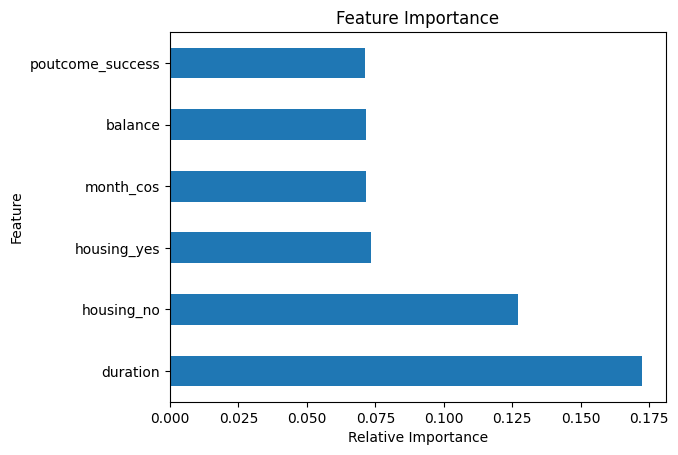

In [693]:
# Plot the feature importances
feature_imp_sorted[:6].plot(kind="barh")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

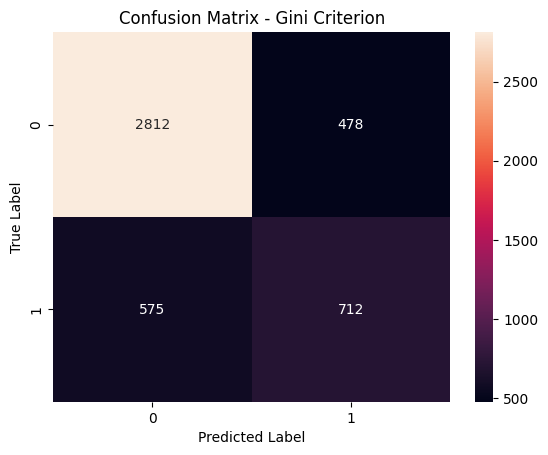

In [706]:
# Decision Tree with Gini Criterion
# Initialize the Decision Tree Classifier with the Gini criterion
gini_dt_clf = DecisionTreeClassifier(
    criterion="gini", random_state=8, max_depth=10, min_samples_leaf=3
)

# Fit the classifier to the training data
gini_dt_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
gini_y_pred = gini_dt_clf.predict(X_test)

# Calculate the confusion matrix
gini_cm = confusion_matrix(y_test, gini_y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(gini_cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Gini Criterion")
plt.show()


In [707]:
# Print the classification report
print("Classification Report - Gini Criterion")
print(classification_report(y_test, gini_y_pred))

Classification Report - Gini Criterion
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3290
           1       0.60      0.55      0.57      1287

    accuracy                           0.77      4577
   macro avg       0.71      0.70      0.71      4577
weighted avg       0.77      0.77      0.77      4577



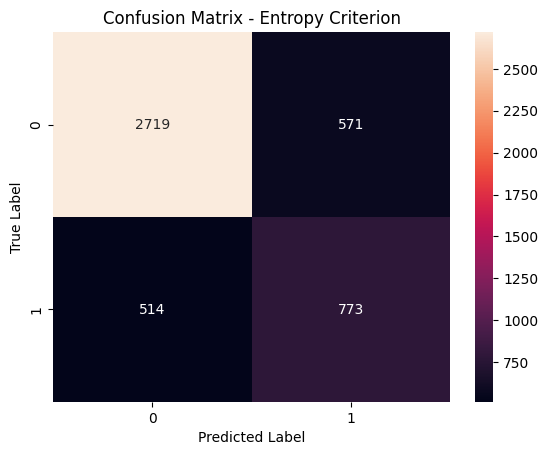

In [719]:
# Decision Tree with Entropy Criterion
# Initialize the Decision Tree Classifier with the entropy criterion
entropy_dt_clf = DecisionTreeClassifier(criterion="entropy", random_state=8, max_depth=10, min_samples_leaf=1)

# Fit the classifier to the training data
entropy_dt_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
entropy_y_pred = entropy_dt_clf.predict(X_test)

# Calculate the confusion matrix
entropy_cm = confusion_matrix(y_test, entropy_y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(entropy_cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Entropy Criterion")
plt.show()

In [720]:
# Print the classification report
print("Classification Report - Entropy Criterion")
print(classification_report(y_test, entropy_y_pred))

Classification Report - Entropy Criterion
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      3290
           1       0.58      0.60      0.59      1287

    accuracy                           0.76      4577
   macro avg       0.71      0.71      0.71      4577
weighted avg       0.77      0.76      0.76      4577



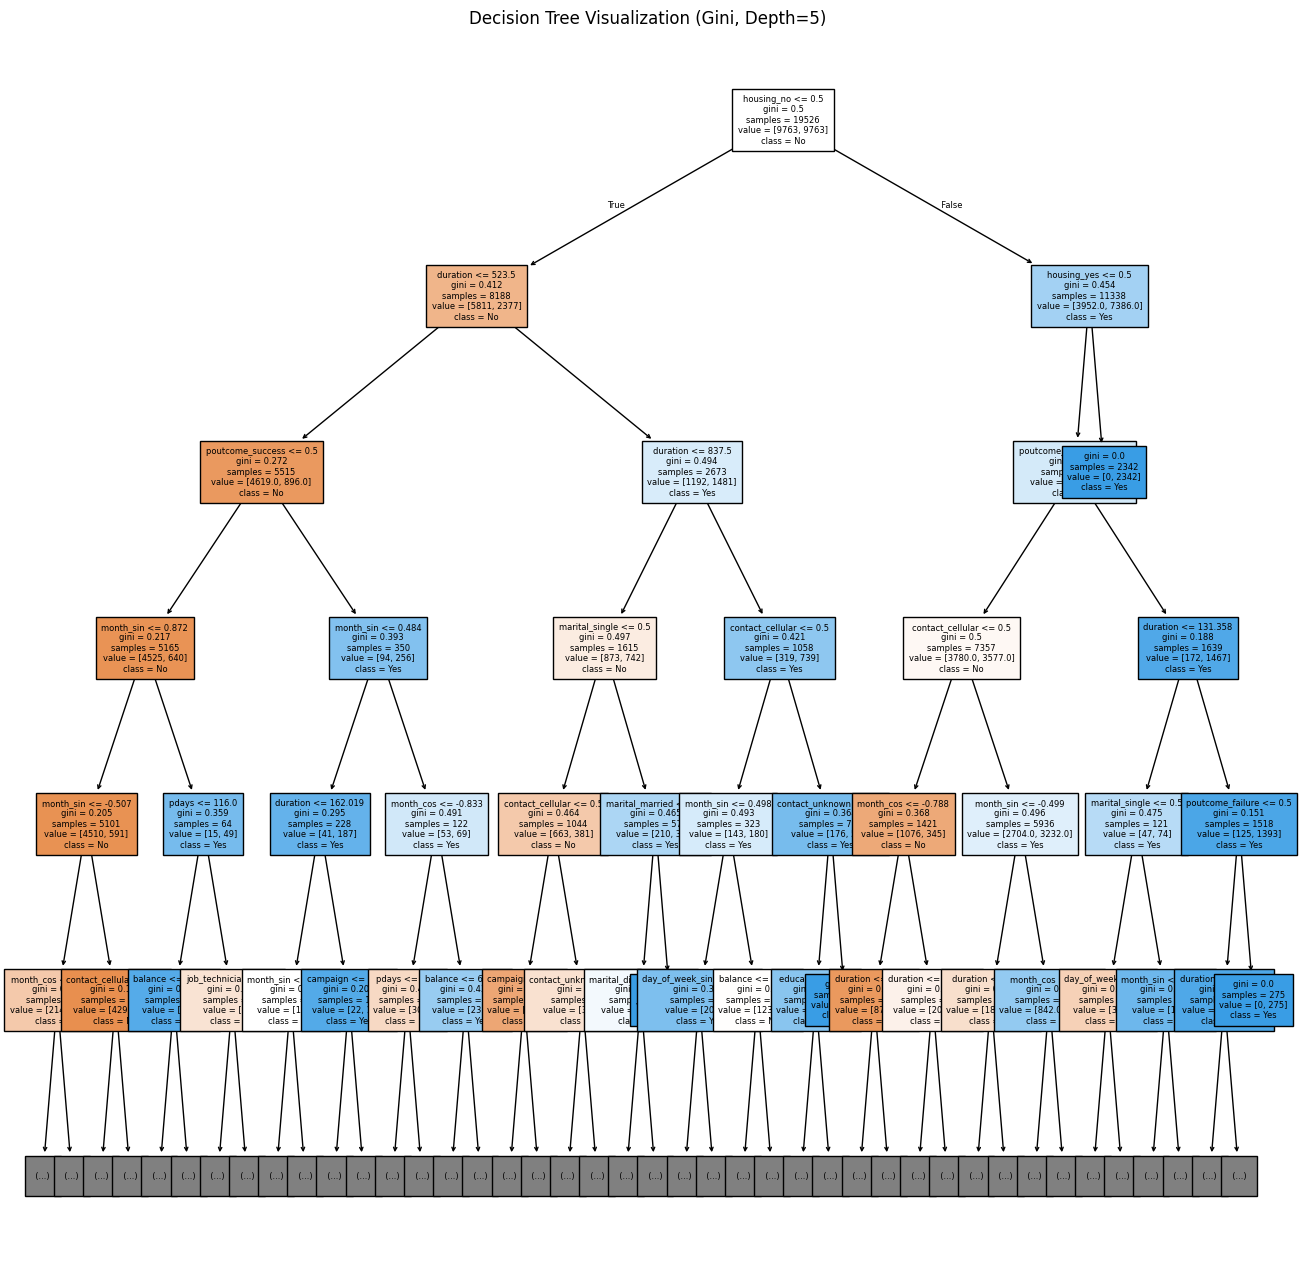

In [728]:
# Print the decision tree visualization with depth of 5.
# Plot the decision tree (with Gini criterion)
plt.figure(figsize=(16, 16))
tree.plot_tree(
    gini_dt_clf,
    feature_names=X.columns,
    class_names=["No", "Yes"],
    max_depth=5,
    filled=True,
    fontsize=6
)
plt.title("Decision Tree Visualization (Gini, Depth=5)")
plt.show()

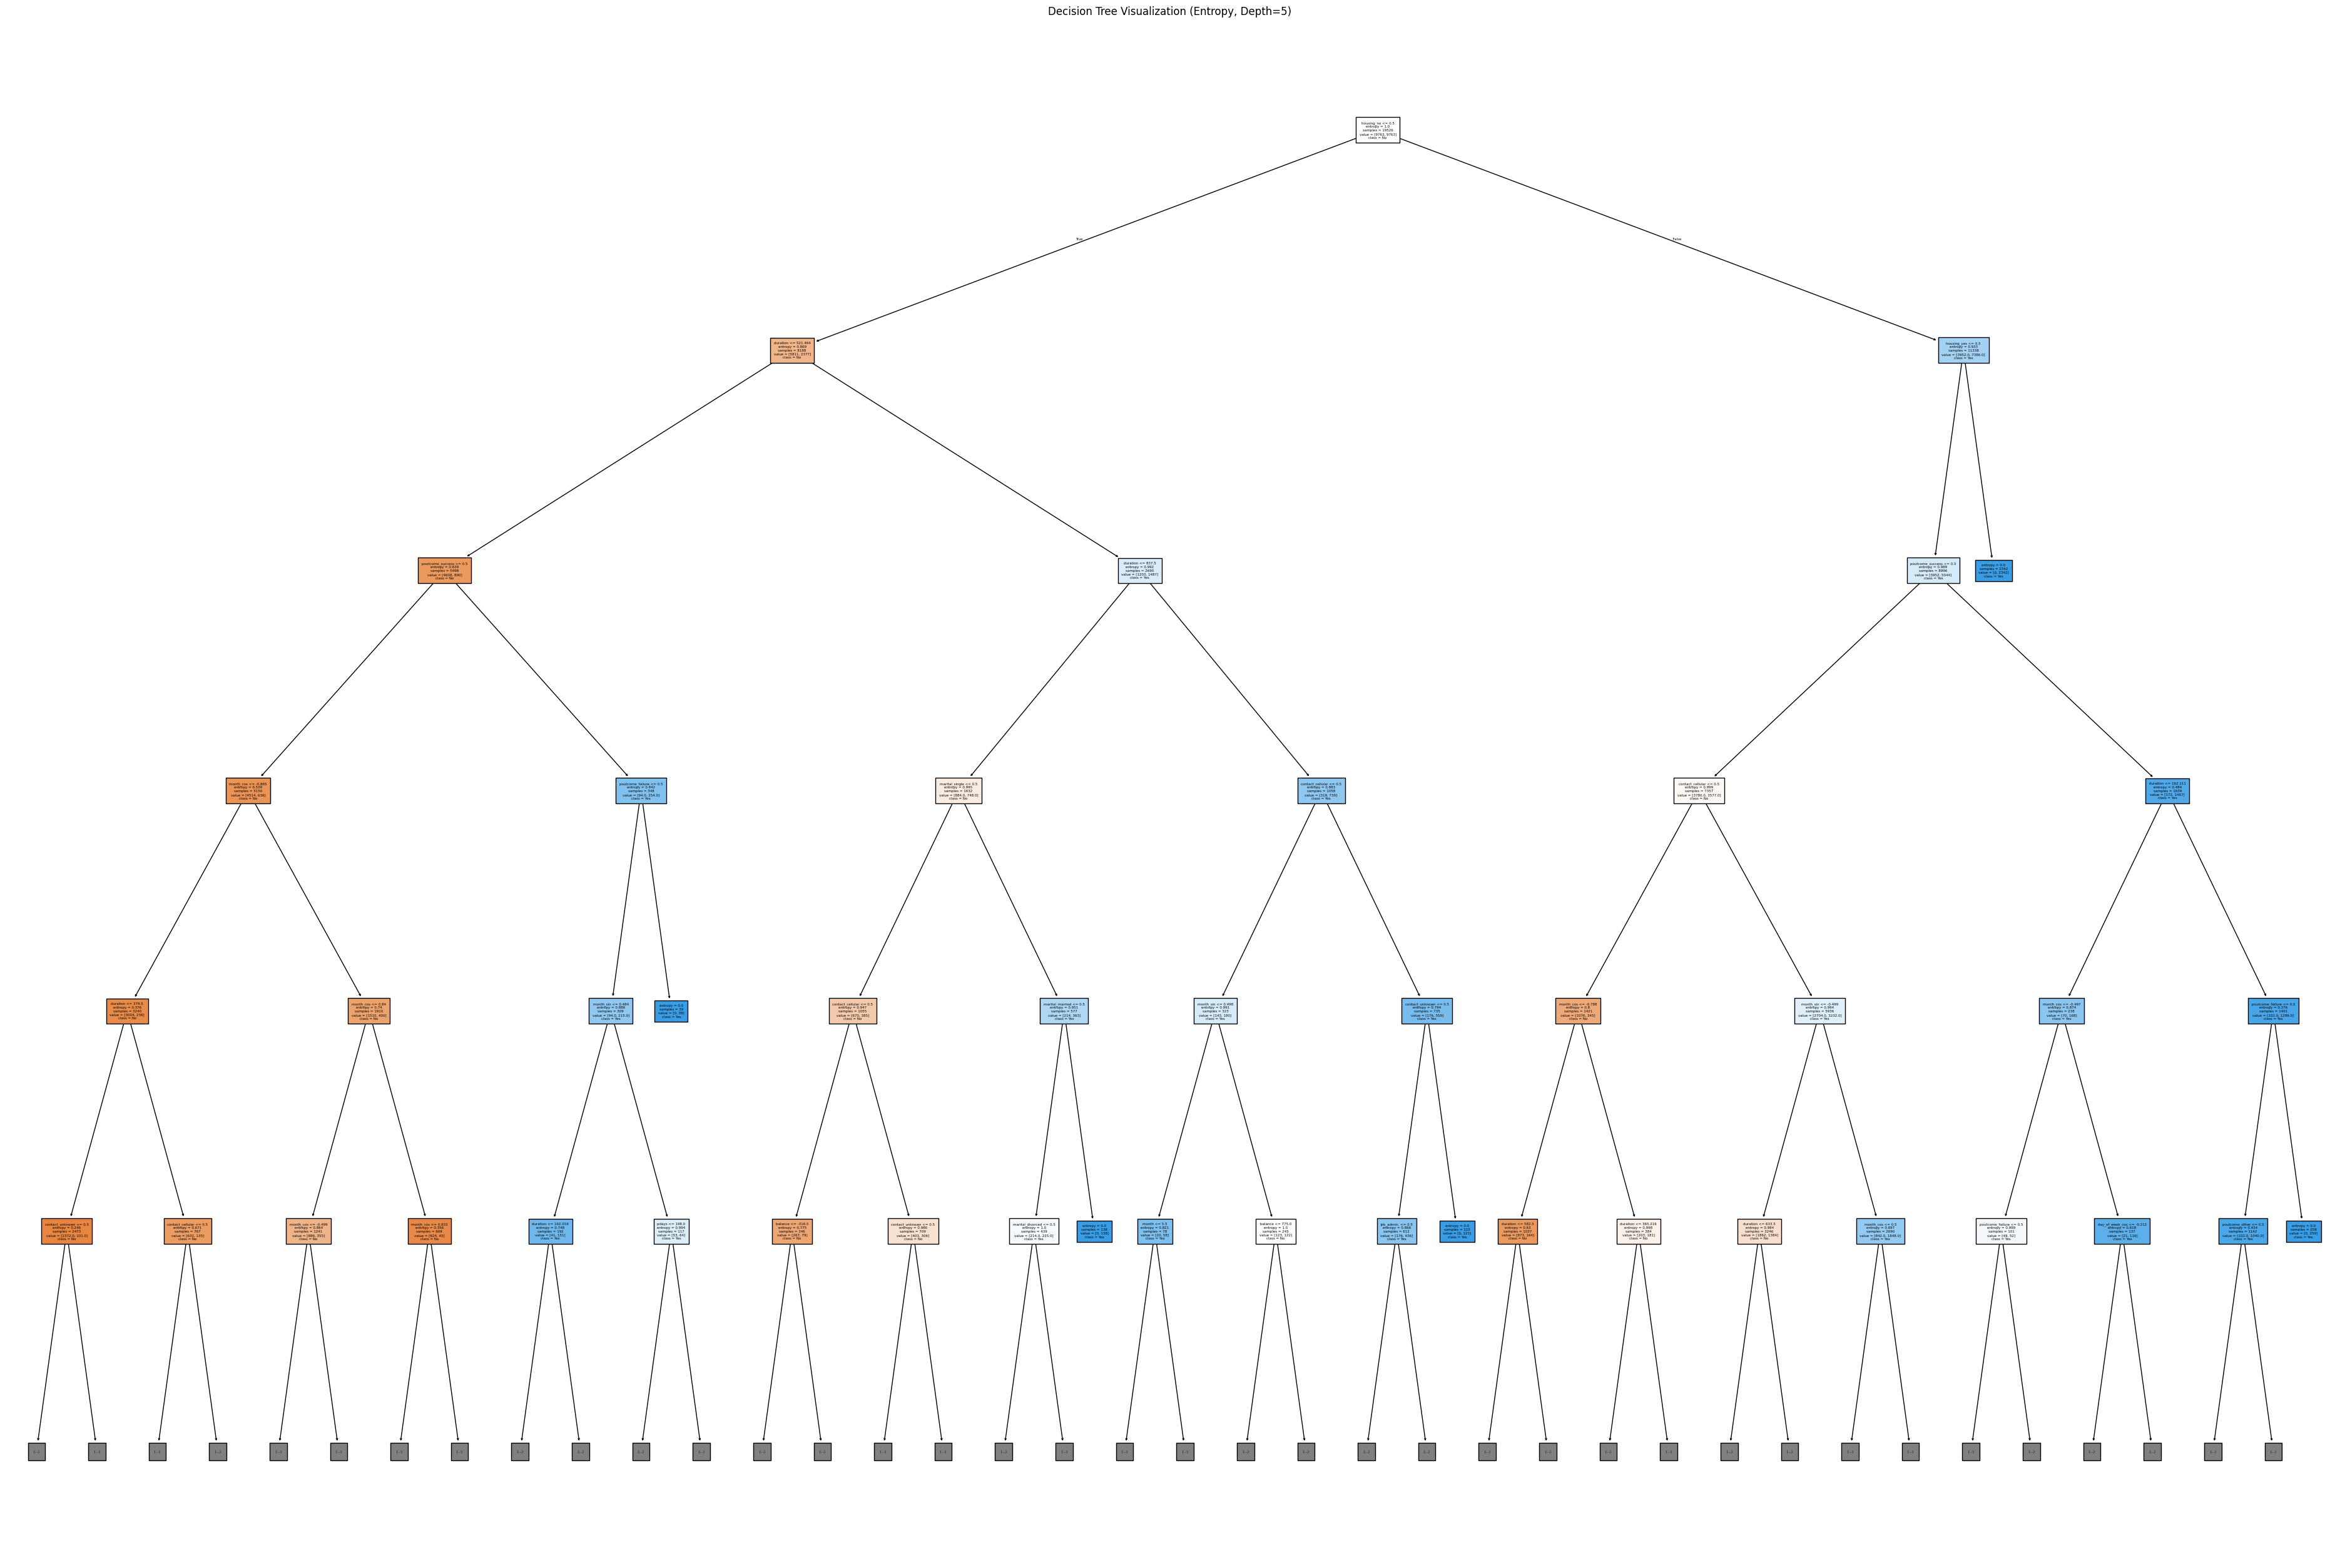

In [731]:
# Plot the decision tree (with entropy criterion)
plt.figure(figsize=(48, 32))
tree.plot_tree(
    entropy_dt_clf,
    feature_names=X.columns,
    class_names=["No", "Yes"],
    max_depth=5,
    filled=True,
    fontsize=4
)
plt.title("Decision Tree Visualization (Entropy, Depth=5)")
plt.show()